In [47]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import hddCRP.behaviorDataHandlers
import seaborn
import pandas as pd
import scipy

In [6]:
with open('Results/sequentialModel/Subject_A1_context_1_run_0.pkl', 'rb') as file:
    results1 = pickle.load(file)

with open('Results/sequentialModel/Subject_A1_context_2_run_0.pkl', 'rb') as file:
    results2 = pickle.load(file)

In [2]:
contexts1 = results1["samples"]["transition_probabilities"]["contexts"];
contexts2 = results2["samples"]["transition_probabilities"]["contexts"];
tps1 = results1["samples"]["transition_probabilities"]["probabilities"][results1["MCMC_info"]["num_warmup_samples"]:,:,:,:];
tps2 = results2["samples"]["transition_probabilities"]["probabilities"][results2["MCMC_info"]["num_warmup_samples"]:,:,:,:];
divs, cs, short_context_indices = hddCRP.behaviorDataHandlers.compute_kl_diveregences_between_transition_probabilities(probs_1=tps1, probs_2=tps2, contexts_1=contexts1, contexts_2=contexts2)
divs = divs.squeeze()

tps2 = tps2.squeeze()
tps1 = tps1.squeeze()

(5000, 3, 9)


In [44]:
context_names = [str(cn[1]) for cn in cs]

KL_deep_shallow = pd.DataFrame(divs[:,0,:].squeeze(), columns=context_names)
KL_shallow_deep = pd.DataFrame(divs[:,1,:].squeeze(), columns=context_names)
JS_deep_shallow = pd.DataFrame(divs[:,2,:].squeeze(), columns=context_names)


In [80]:
# one way I'm trying to make a null distribution: what is typical KL divergence between two samples from the same posterior?
seed = 22
rng = np.random.Generator(np.random.MT19937(seed))


null_ps_1 = np.zeros_like(tps2)
null_ps_2 = np.zeros_like(tps2)

for ii in range(tps2.shape[2]):
    null_ps_1[:,:,ii] = tps2[:,:,ii]
    null_ps_2[:,:,ii] = tps2[rng.permutation(tps2.shape[0]),:,ii]

divs_null, *_ = hddCRP.behaviorDataHandlers.compute_kl_diveregences_between_transition_probabilities(probs_1=null_ps_1, probs_2=null_ps_2, contexts_1=contexts2, contexts_2=contexts2)
divs_null = divs_null.squeeze()
contexts_null = [xx + "NULL" for xx in contexts2]

divs_null_median = np.median(divs_null,axis=0).squeeze()



# KL_deep_shallow_with_null = KL_deep_shallow.copy()
# for ii in range(divs_null.shape[2]):
#     KL_deep_shallow_with_null[contexts_null[ii]] = divs_null[:,0,ii]

# KL_deep_shallow_with_null.sort_index(axis="columns", inplace=True)
# ps_null = np.zeros((divs.shape[2]))
# for ii in range(divs.shape[2]):
#     _, ps_null[ii] = scipy.stats.ranksums(divs[:,0,ii], divs_null[:,0,ii], alternative='greater')
# print(ps_null)
# print(ps_null<0.01)

(3, 9)

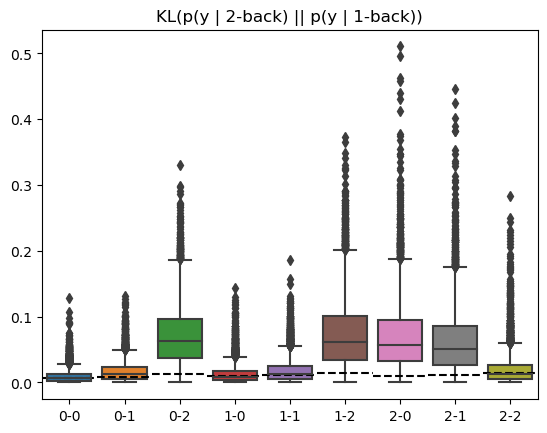

In [81]:
seaborn.boxplot(KL_deep_shallow).set(title="KL(p(y | 2-back) || p(y | 1-back))")

# draw dashed line where the median would be for "E[KL(p(y | 2-back) || p(y | 2-back))]"
for ii, yy in enumerate(divs_null_median[0,:]):
    plt.plot([ii-0.5,ii+0.5],[yy,yy],'k--')

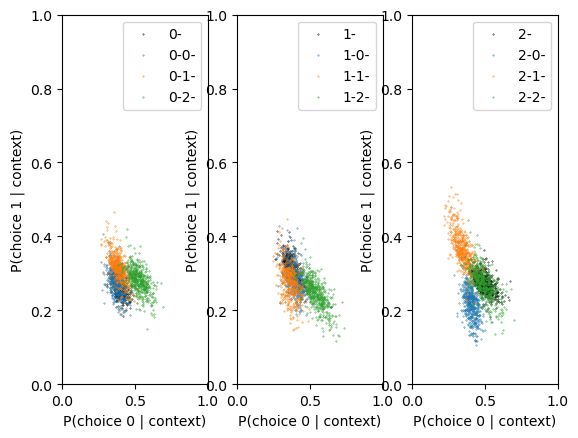

In [75]:
num_contexts = len(short_context_indices)
num_shallow_contexts = np.unique(short_context_indices).size;

shallow_context_found = np.zeros((num_shallow_contexts), dtype=bool)

for ii in range(num_shallow_contexts):
    ax = plt.subplot(1,num_shallow_contexts,ii+1)

    plt.scatter(tps1[::10, 0, ii], tps1[::10, 1, ii], s=0.1, color=[0,0,0])

    legend_items = [contexts1[ii]]

    two_backs = np.where(short_context_indices == ii)[0]
    for jj in two_backs:
        plt.scatter(tps2[::10, 0, jj], tps2[::10, 1, jj], s=0.1)
        legend_items += [contexts2[jj]]

    plt.legend(legend_items)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("P(choice 0 | context)")
    plt.ylabel("P(choice 1 | context)")

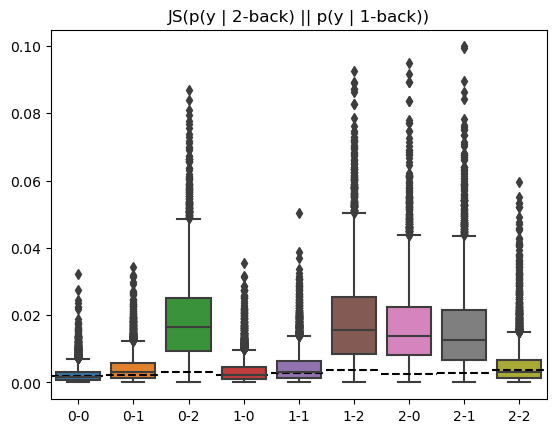

In [82]:
seaborn.boxplot(JS_deep_shallow).set(title="JS(p(y | 2-back) || p(y | 1-back))") # jensen-shannon divergence

# draw dashed line where the median would be for "E[JS(p(y | 2-back) || p(y | 2-back))]"
for ii, yy in enumerate(divs_null_median[2,:]):
    plt.plot([ii-0.5,ii+0.5],[yy,yy],'k--')